In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

python inference.py --dataset_location data/nacc_scaled_corrected.csv --dataset_id nacc

python inference.py --dataset_location data/nacc_scaled_corrected.csv --dataset_id nacc --do_single_pass

In [2]:
nacc_diag = pd.read_csv('../data/nacc_diagnosis.csv', index_col=0)
nacc_diag.shape

(5209, 1)

In [3]:
res_df = pd.read_csv('latest_output_nacc_50.csv', index_col=0)
res_df

,mean,std
nacc_id,,
34,0.754137,0.190174
225,0.933381,0.085771
511,0.467415,0.259353
531,0.497308,0.269715
920,0.025401,0.038529
...,...,...
999346,0.985245,0.023443
999546,0.189503,0.176066
999566,0.399080,0.229956


In [4]:
joined_df = res_df.join(nacc_diag, how='inner')
joined_df

,mean,std,diagnosis
nacc_id,,,
34,0.754137,0.190174,AD
225,0.933381,0.085771,OD
511,0.467415,0.259353,AD
531,0.497308,0.269715,OD
920,0.025401,0.038529,Control
...,...,...,...
999346,0.985245,0.023443,AD
999546,0.189503,0.176066,Control
999566,0.399080,0.229956,OND


In [5]:
joined_df['diagnosis'] = joined_df['diagnosis'].map({'AD': 1, 'OD': 0, 'Control': 0, 'OND': 0})
joined_df

,mean,std,diagnosis
nacc_id,,,
34,0.754137,0.190174,1
225,0.933381,0.085771,0
511,0.467415,0.259353,1
531,0.497308,0.269715,0
920,0.025401,0.038529,0
...,...,...,...
999346,0.985245,0.023443,1
999546,0.189503,0.176066,0
999566,0.399080,0.229956,0


## MC-Drop vs single-pass: AUC Roc Curve

In [6]:
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


In [7]:
single_pass = pd.read_csv('latest_output_nacc_1.csv', index_col=0)
single_pass = single_pass.join(nacc_diag, how='inner')
single_pass['diagnosis'] = single_pass['diagnosis'].map({'AD': 1, 'OD': 0, 'Control': 0, 'OND': 0})
single_pass

,mean,std,diagnosis
nacc_id,,,
34,0.846376,NaN,1
225,0.983831,NaN,0
511,0.462805,NaN,1
531,0.617238,NaN,0
920,0.006656,NaN,0
...,...,...,...
999346,0.997336,NaN,1
999546,0.083502,NaN,0
999566,0.358801,NaN,0


In [8]:
def plot_all_roc_curves(mcdrop_df, singlpass_df):
    def plot_roc_stuff(tmp_df, label, color):
        preds = tmp_df['mean']
        fpr, tpr, thresholds = metrics.roc_curve(tmp_df['diagnosis'], preds)
        roc_auc = metrics.auc(fpr, tpr)

        # Youden’s J statistic
        J = tpr - fpr
        ix = np.argmax(J)
        best_thresh = thresholds[ix]
        print(f'Best treshold for {label}: {best_thresh}')

        plt.plot(fpr, tpr, 'b', label = f'AUC {label} = %0.2f' % roc_auc, color=color)
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best {label}')

    plt.subplots(figsize=(20, 10))
    plt.title('Receiver Operating Characteristic')
    plot_roc_stuff(mcdrop_df, 'MC-Drop', 'orange')
    plot_roc_stuff(singlpass_df, 'Single Pass', 'green')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.close()

Best treshold for MC-Drop: 0.5115083456039429
Best treshold for Single Pass: 0.5894964933395386


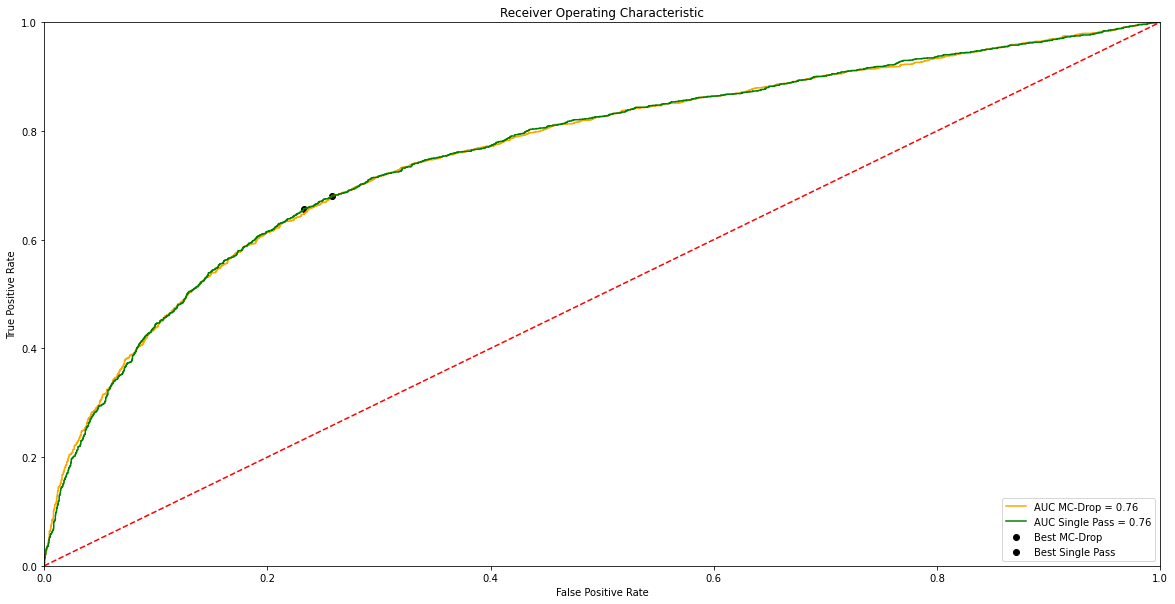

In [9]:
plot_all_roc_curves(joined_df, single_pass)

## MC-Drop (uncertainty) vs MC-Drop (delta) vs single-pass (delta)

In [10]:
def populate_arrs_for_df(df, accs_arr, sens_arr, spes_arr, people_arr, ppvs_arr, npvs_arr):
    probs = tmp_df['mean'].values
    probs[probs < 0.5] = 0
    probs[probs > 0.5] = 1
    
    tn, fp, fn, tp = metrics.confusion_matrix(tmp_df['diagnosis'].values, probs).ravel()
    specificity = tn / (tn + fp)
    sensitivty = tp / (tp + fn)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    
    accs_arr.append(metrics.accuracy_score(tmp_df['diagnosis'].values, probs))
    sens_arr.append(sensitivty)
    spes_arr.append(specificity)
    people_arr.append(tmp_df.shape[0])
    ppvs_arr.append(ppv)
    npvs_arr.append(npv)
    

### MC-Drop with uncertainty thresholding

In [11]:
accs = []
sens = []
spes = []
people = []
ppvs = [] # precision / positive predictive value
npvs = [] # negative predictive value
for std_val in np.arange(0.015, 0.36, 0.001):
    
    tmp_df = joined_df.loc[joined_df['std'] < std_val, :]
    populate_arrs_for_df(tmp_df, accs, sens, spes, people, ppvs, npvs)

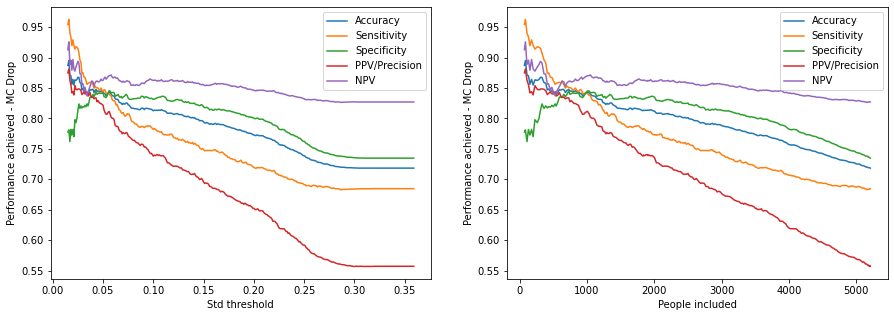

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(np.arange(0.015, 0.36, 0.001), accs, label='Accuracy')
axs[0].plot(np.arange(0.015, 0.36, 0.001), sens, label='Sensitivity')
axs[0].plot(np.arange(0.015, 0.36, 0.001), spes, label='Specificity')
axs[0].plot(np.arange(0.015, 0.36, 0.001), ppvs, label='PPV/Precision')
axs[0].plot(np.arange(0.015, 0.36, 0.001), npvs, label='NPV')
axs[0].set_xlabel('Std threshold')
axs[0].set_ylabel('Performance achieved - MC Drop')
axs[0].legend()

axs[1].plot(people, accs, label='Accuracy')
axs[1].plot(people, sens, label='Sensitivity')
axs[1].plot(people, spes, label='Specificity')
axs[1].plot(people, ppvs, label='PPV/Precision')
axs[1].plot(people, npvs, label='NPV')
axs[1].set_xlabel('People included')
axs[1].set_ylabel('Performance achieved - MC Drop')
axs[1].legend()

plt.show()

### MC-Drop vs Single-pass with probability-delta thresholding

In [13]:
accs_delta_mc, accs_delta_1 = [], []
sens_delta_mc, sens_delta_1 = [], []
spes_delta_mc, spes_delta_1 = [], []
people_delta_mc, people_delta_1 = [], []
ppvs_delta_mc, ppvs_delta_1 = [], []
npvs_delta_mc, npvs_delta_1 = [], []

for delta_val in np.arange(0.012, 0.51, 0.001):

    tmp_df = joined_df.loc[(joined_df['mean'] < delta_val) | (joined_df['mean'] > 1- delta_val), :]
    populate_arrs_for_df(tmp_df, accs_delta_mc, sens_delta_mc, spes_delta_mc, people_delta_mc, ppvs_delta_mc, npvs_delta_mc)
    
    tmp_df = single_pass.loc[(single_pass['mean'] < delta_val) | (single_pass['mean'] > 1- delta_val), :]
    populate_arrs_for_df(tmp_df, accs_delta_1, sens_delta_1, spes_delta_1, people_delta_1, ppvs_delta_1, npvs_delta_1)

In [18]:
def plot_across_metrics(x_vals_mc, x_vals_1, x_label):
    fig, axs = plt.subplots(1, 5, figsize=(20,5))

    axs[0].plot(x_vals_mc, accs_delta_mc, label='Accuracy - MC Drop')
    axs[0].plot(x_vals_1, accs_delta_1, label='Accuracy - Single')

    axs[1].plot(x_vals_mc, sens_delta_mc, label='Sensitivity - MC Drop')
    axs[1].plot(x_vals_1, sens_delta_1, label='Sensitivity - Single')

    axs[2].plot(x_vals_mc, spes_delta_mc, label='Specificity - MC Drop')
    axs[2].plot(x_vals_1, spes_delta_1, label='Specificity - Single')
    
    axs[3].plot(x_vals_mc, ppvs_delta_mc, label='PPV/Precision - MC Drop')
    axs[3].plot(x_vals_1, ppvs_delta_1, label='PPV/Precision - Single')
    
    axs[4].plot(x_vals_mc, npvs_delta_mc, label='NPV - MC Drop')
    axs[4].plot(x_vals_1, npvs_delta_1, label='NPV - Single')

    for ax in axs:
        ax.set_xlabel(x_label)
        ax.set_ylabel('Performance achieved')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

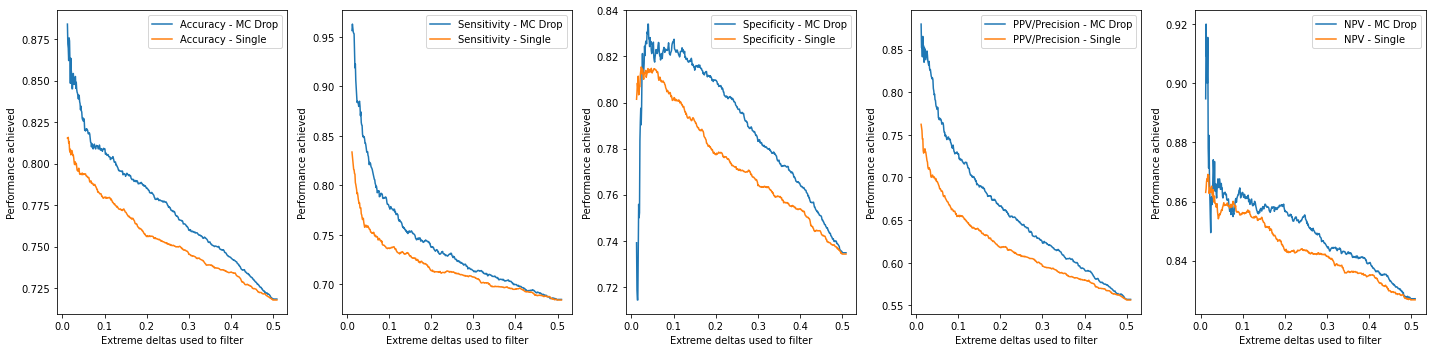

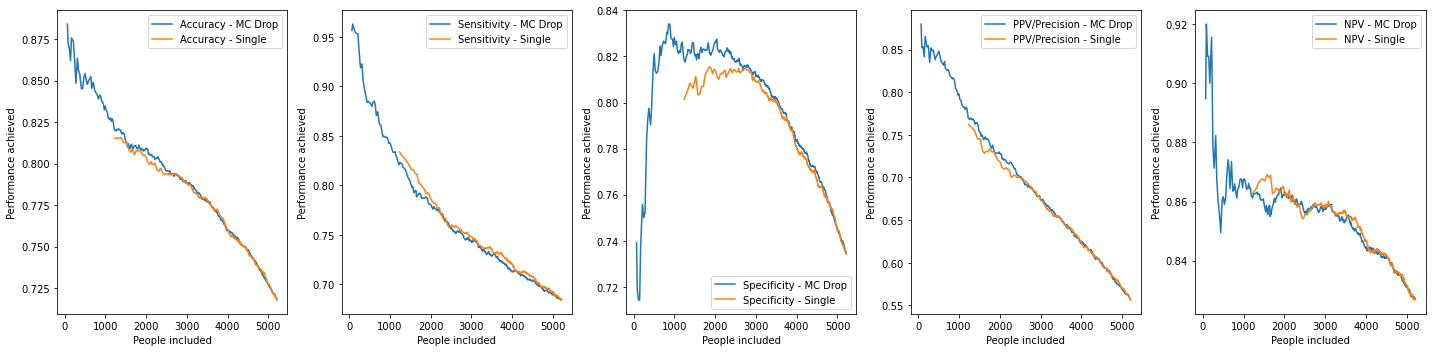

In [19]:
plot_across_metrics(np.arange(0.012, 0.51, 0.001), np.arange(0.012, 0.51, 0.001), 'Extreme deltas used to filter')
plot_across_metrics(people_delta_mc, people_delta_1, 'People included')


## Comparing the three approaches across people included

In [16]:
def plot_people_vs_var(vals_mc, vals_1, vals_uncert, metric_name):
    plt.subplots(figsize=(20,5))
    plt.plot(people_delta_mc, vals_mc, 'o-', label='Considering delta - MC Drop')
    plt.plot(people_delta_1, vals_1, '|-', label='Considering delta - Single')
    plt.plot(people, vals_uncert, 'x-', label='Considering uncertainty')
    plt.xlabel('People included')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

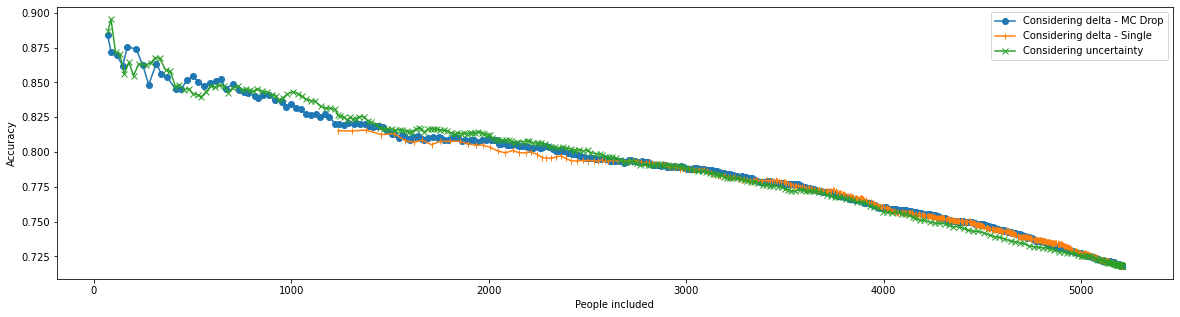

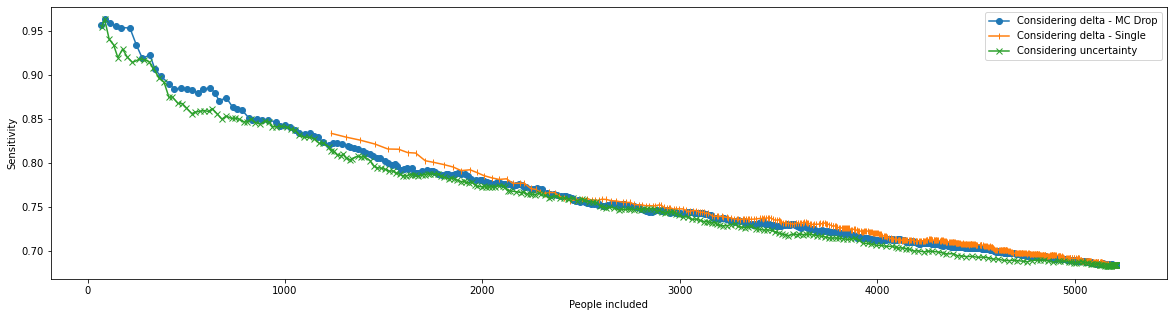

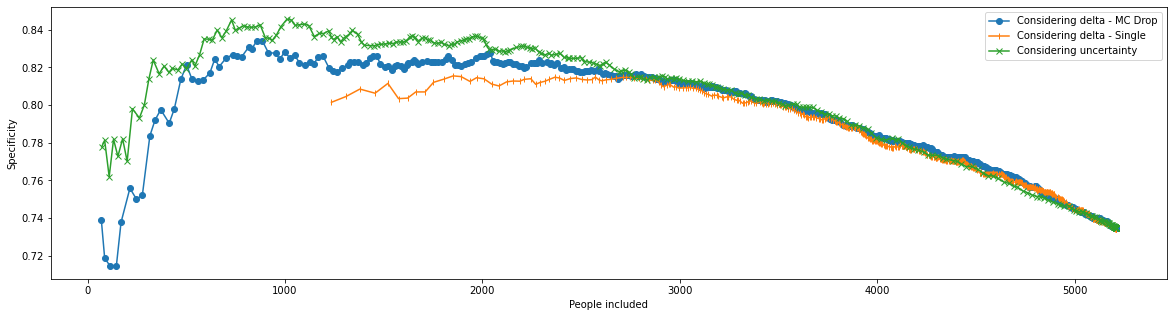

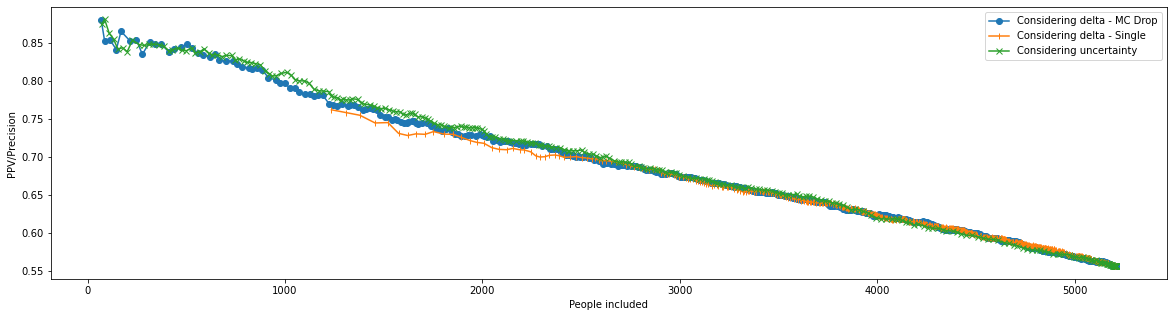

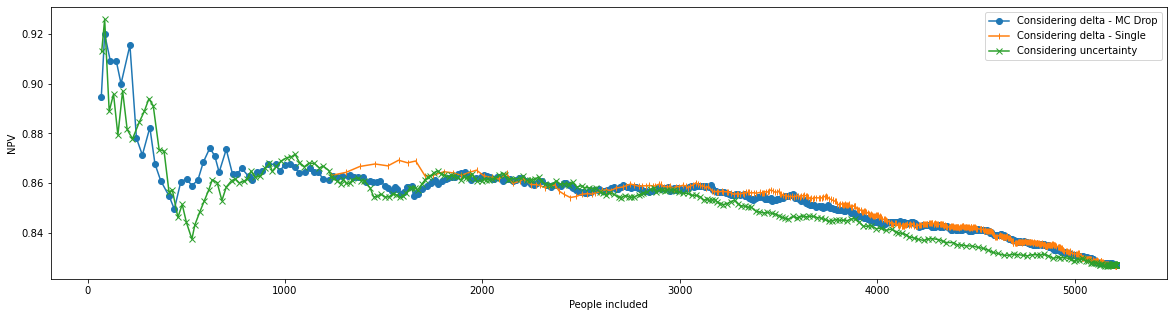

In [17]:
plot_people_vs_var(accs_delta_mc, accs_delta_1, accs, 'Accuracy')
plot_people_vs_var(sens_delta_mc, sens_delta_1, sens, 'Sensitivity')
plot_people_vs_var(spes_delta_mc, spes_delta_1, spes, 'Specificity')
plot_people_vs_var(ppvs_delta_mc, ppvs_delta_1, ppvs, 'PPV/Precision')
plot_people_vs_var(npvs_delta_mc, npvs_delta_1, npvs, 'NPV')